In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [3]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = '/home/jovyan/work/icedrift/AOI/Fram srtarit/S1B_EW_GRDM_1SDH_20200713T113234_20200713T113334_022452_02A9CE_22C3.SAFE'
f2 = '/home/jovyan/work/icedrift/AOI/Fram srtarit/S1B_EW_GRDM_1SDH_20200714T103514_20200714T103614_022466_02AA37_1FD8.SAFE'
# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HH', remove_spatial_mean=True) 
n2 = get_n(f2, bandName='sigma0_HH', remove_spatial_mean=True) 
#HV
#n1 = get_n(f1)
#n2 = get_n(f2)

VMIN:  -1.8232171773910522
VMAX:  2.9809950566291796
VMIN:  -1.8584856986999512
VMAX:  3.0404358386993415


In [4]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
#c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.7)

In [5]:
c1, r1 = np.meshgrid(
    np.arange(1,n1.shape()[1],250),
    np.arange(1,n1.shape()[0],250))
c1, r1 = c1.flatten(), r1.flatten()
lon1ft, lat1ft = n1.transform_points(c1, r1)

In [6]:
c1, r1 = np.meshgrid(
    np.arange(1,n1.shape()[1],250),
    np.arange(1,n1.shape()[0],250))
c1, r1 = c1.flatten(), r1.flatten()
lon1ft, lat1ft = n1.transform_points(c1, r1)
c2, r2 = n2.transform_points(lon1ft, lat1ft, DstToSrc=True)

margin = 200
gpi = ((c1 > margin) * (r1 > margin) * (c1 < (n1.shape()[1]-margin)) * (r1 < (n1.shape()[1]-margin)) *
       (c2 > margin) * (r2 > margin) * (c2 < (n2.shape()[1]-margin)) * (r2 < (n2.shape()[1]-margin)))

c1, r1, c2, r2 = c1[gpi], r1[gpi], c2[gpi], r2[gpi] 

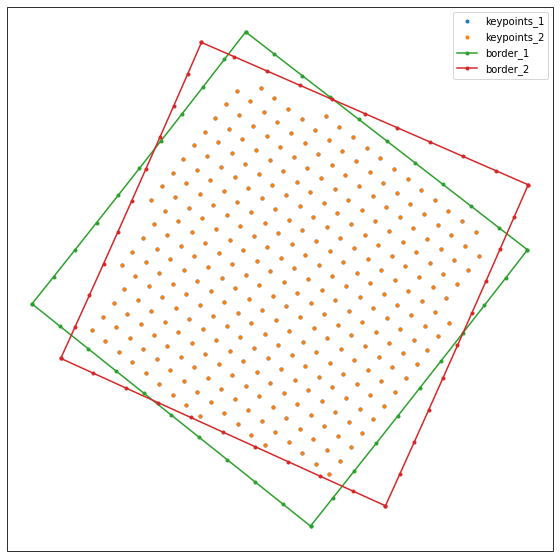

In [7]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

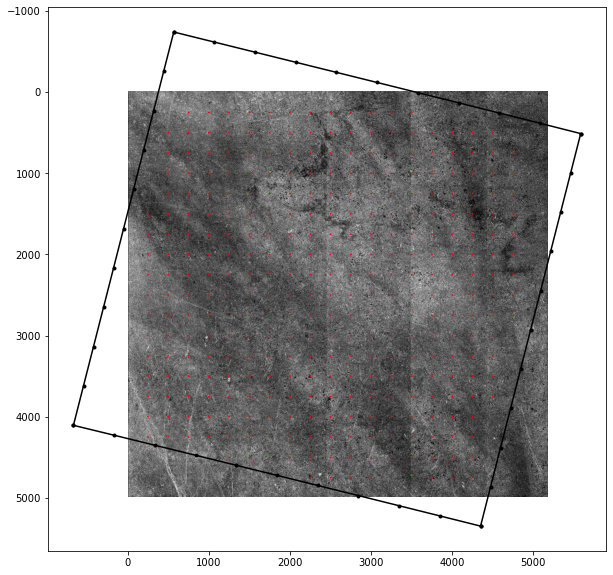

In [8]:
# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.2)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

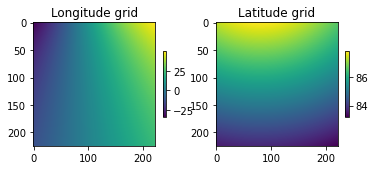

[[-33.45552429 -33.12375533 -32.78946034 ...  49.09175349  49.29453427
   49.49566023]
 [-33.23838811 -32.90771514 -32.57455365 ...  48.85759765  49.06061588
   49.26198895]
 [-33.02373455 -32.69416357 -32.362141   ...  48.62510204  48.82834264
   49.02994782]
 ...
 [-13.09894104 -12.94022333 -12.78130331 ...  22.11735964  22.26071517
   22.40377768]
 [-13.06213496 -12.90383239 -12.74532916 ...  22.05918468  22.20224166
   22.34500767]
 [-13.02553157 -12.86764211 -12.70955362 ...  22.00129981  22.14405912
   22.28652952]]


In [9]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413) or 3996
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 m
dom_pm = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 2000 2000')


# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = dom_pm.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()
print(lon1pm)

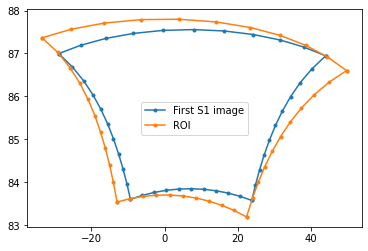

In [10]:
# plot coverage of the first S1 image and ROI
plt.plot(*n1.get_border(), '.-', label='First S1 image')
plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [11]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                           min_border=200, max_border=200,
                                                          srs=srs.ExportToProj4())

100% 00042.3 03204.0 00658.0 03854.0 +03.0 0.24 2.1259% 02371.1 04319.8 03044.0 04511.0 +00.0 0.26 6.5169% 01903.1 04246.9 02688.0 04647.0 -03.0 0.21 4.91
 Pattern matching - OK! (150 sec)


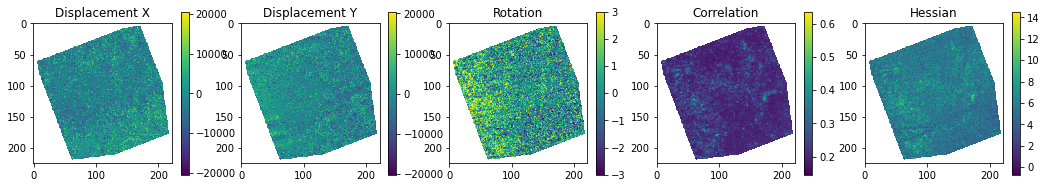

In [12]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

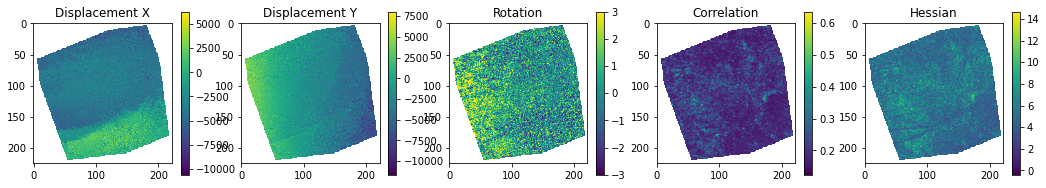

In [42]:
# plot retrieved matrices for the second run (see below)
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm2, vpm2, apm2, rpm2, hpm2]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

In [13]:
# image_1 in stereographic projection

# domain of interest with resolution 500 m for SAR image reprojection (-te - extent -tr  - resolution -ts - size
dom_sar = Domain(srs.wkt, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 500 500')
n1.reproject(dom_sar) #n1.export
n1b1pro = n1[1]
n1.undo()

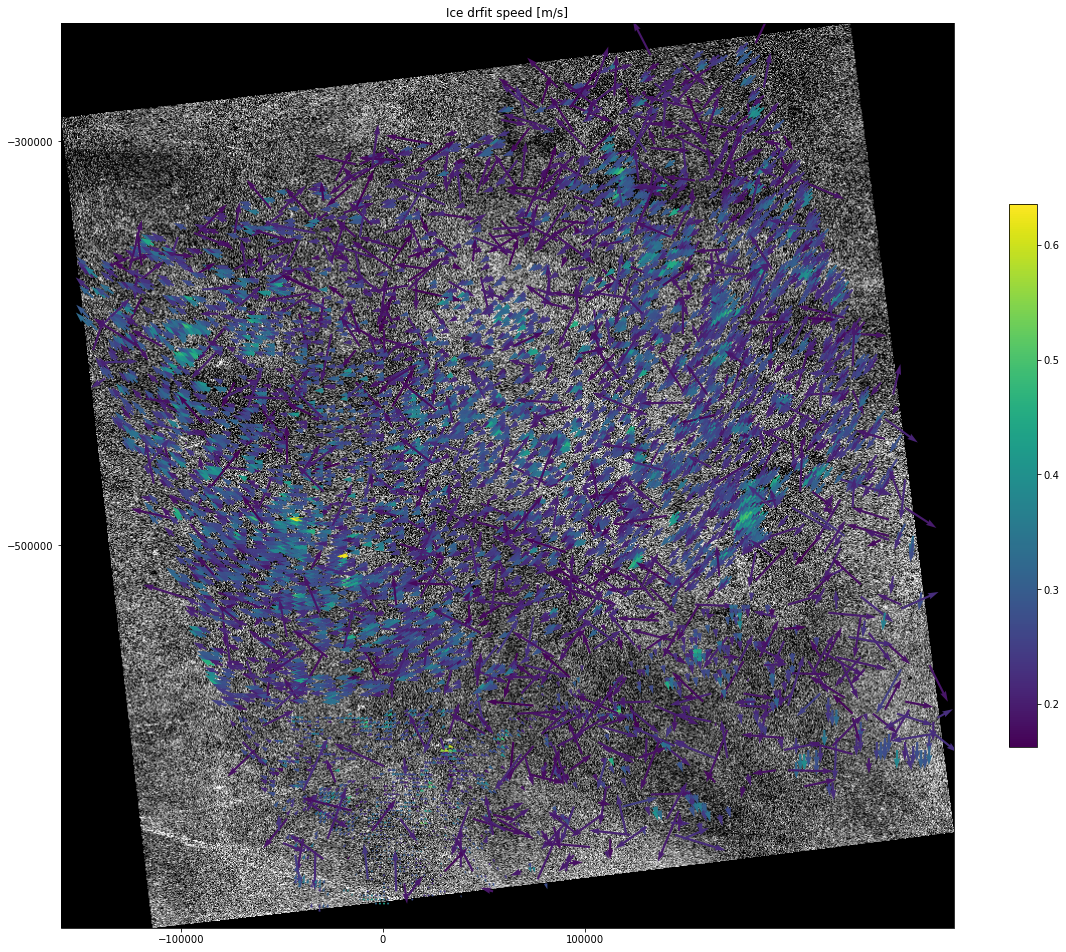

In [23]:
# compute ice drift speed [m/s]
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u = upm / delta_t
v = vpm / delta_t

# plot valid vectors in Polar stereographic projection
gpi = (hpm>7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)

# spacial reference for plotting (-45 and 70 for 3413)
crs = ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=75)

plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)

ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi], rpm[gpi], scale=4)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [14]:
#gpi = (hpm > 7)
gpi= (rpm>0.4)
print(gpi.shape, u.shape)

(277, 280) (277, 280)


In [15]:
# Second pattern matching with filtered input. - CG\HANGE LON1PM TO THE RIGHT ARRAY!

n1c3, n1r3 = n1.transform_points(lon1pm[gpi].flatten(), lat1pm[gpi].flatten(), 1)
n2c4, n2r4 = n2.transform_points(lon2pm[gpi].flatten(), lat2pm[gpi].flatten(), 1)


In [16]:
#Second run
upm2, vpm2, apm2, rpm2, hpm2, lon2_2pm, lat2_2pm = pattern_matching(lon1pm, lat1pm, n1, n1c3, n1r3, n2, n2c4, n2r4,
                                                          srs=srs.ExportToProj4())

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


100% 01894.4 04857.8 00250.0 04932.0 +03.0 0.16 3.0037% 03242.0 01687.3 02252.0 02146.0 -03.0 0.43 8.3432% 02657.0 01139.2 01775.0 01501.0 -03.0 0.25 5.8028% 01154.1 00061.3 00424.0 00124.0 -03.0 0.12 6.7647% 03647.0 02336.3 02512.0 02849.0 -03.0 0.40 12.7251% 01295.9 01098.9 00386.0 01152.0 -03.0 0.09 9.3961% 02224.5 02050.8 01131.0 02285.0 +00.0 0.33 10.7356% 05082.2 03576.6 03675.0 04351.0 -03.0 0.51 9.8252% 01260.9 01108.1 00377.0 01155.0 +03.0 0.10 9.6675% 03184.2 03290.8 01801.0 03742.0 -03.0 0.21 6.3360% 02346.9 02093.6 01252.0 02346.0 +03.0 0.25 4.97
 Pattern matching - OK! ( 17 sec)


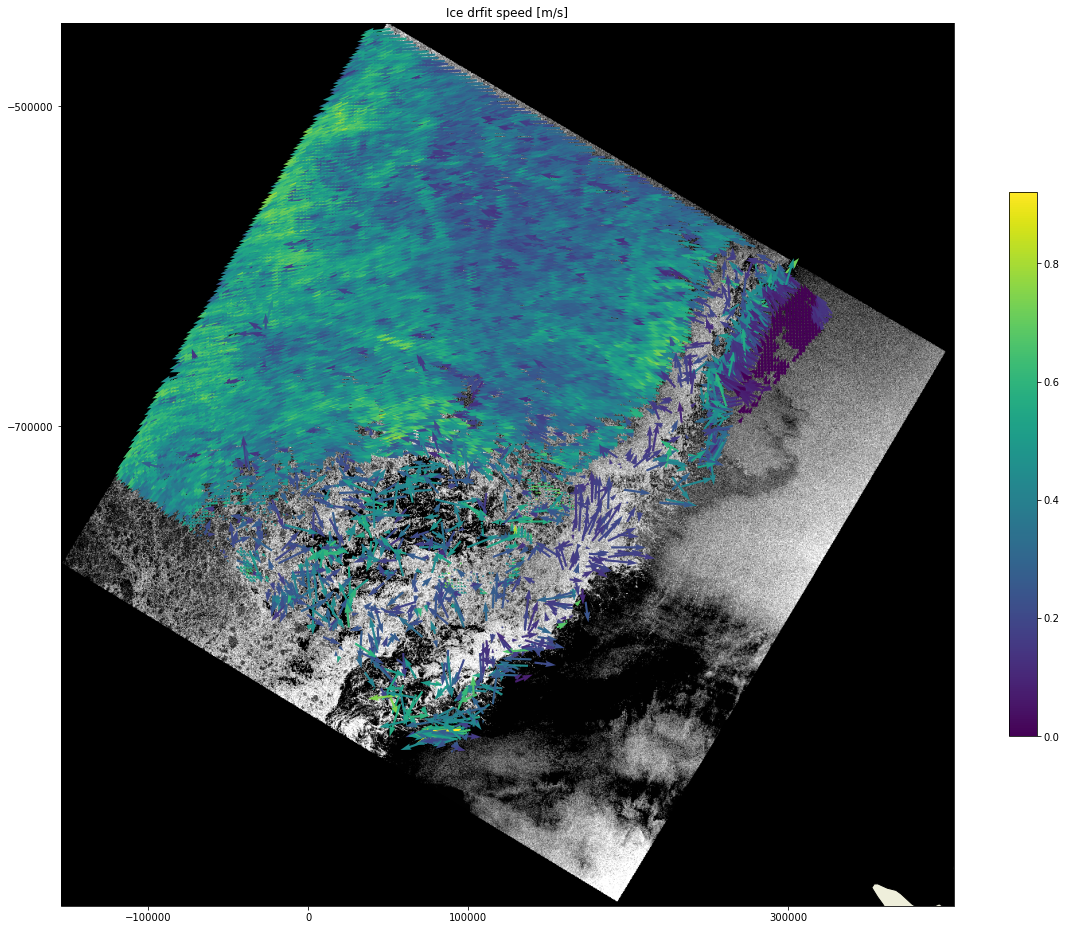

In [17]:
# compute ice drift speed [m/s] for the second run results
delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
u2 = upm2 / delta_t
v2 = vpm2 / delta_t

# plot valid vectors in Polar stereographic projection
gpi = (hpm>5) 
# X/Y grids in polar stereographic projection covering image_1
x1pm2, y1pm2 = dom_pm.get_geolocation_grids(dst_srs=srs)

# spacial reference for plotting (-45 and 70 for 3413)
crs = ccrs.NorthPolarStereo(central_longitude=0, true_scale_latitude=75)

plt.figure(figsize=(20,20))
ax = plt.axes(projection=crs)

ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm2[gpi], y1pm2[gpi], u2[gpi], v2[gpi], rpm2[gpi], scale=5)
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm2.min(), x1pm2.max()])
ax.set_ylim([y1pm2.min(), y1pm2.max()])
plt.show()

In [43]:
#EXPORTING DATA TO 'DEFORMATION' NOTEBOOK, GETTING BACK RESULTS AND VISUALIZING DEFORMATION
%store upm
%store vpm
%store rpm
%store f1
%store f2

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'f1' (str)
Stored 'f2' (str)


In [19]:
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement, to calculate speed use delta_t)

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm.flatten(),lat1pm.flatten(), lon2pm.flatten(),lat2pm.flatten()

#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

u_flat, v_flat, a_flat, r_flat, h_flat = upm.flatten(), vpm.flatten(), apm.flatten(), rpm.flatten(), hpm.flatten()

In [46]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, u_flat, v_flat, a_flat, r_flat, h_flat)
header=['lon1','lat1', 'lon2','lat2', 'u','v', 'a','r', 'h']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/13-14_july_2020/13-14_july_drift_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [47]:
#Exporting for Chalmers
pixel_size = 2000
# drift field displacement in pixel
u_pix = upm/pixel_size
v_pix = vpm/pixel_size

u_pix_flat, v_pix_flat = u_pix.flatten(), v_pix.flatten()

In [48]:
#Exporting for Chalmers
points=zip(lon1_flat,lat1_flat, u_pix_flat, v_pix_flat)
header=['y1','x1', 'dy','dx']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/to_chalmers/13-14.07.20_drift_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [49]:
#Exporting quality parametres
points_q=zip(lon1_flat,lat1_flat, r_flat, h_flat)
header_q=['y1','x1','r', 'h']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/to_chalmers/13-14.07_corr_hessian_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header_q) 
    out.writerows(points_q)

In [68]:
#exporting from "Deformation.ipynb" filtered displacament in pixels for r>0.3
%store -r u_map
%store -r v_map

u_int_flat, v_int_flat = u_map.flatten(), v_map.flatten()

In [69]:
#exporting filtered data
points_int=zip(lon1_flat,lat1_flat, u_int_flat, v_int_flat)
header_int=['y1','x1', 'dy','dx']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output//2000m/to_chalmers/01-02.09.20_drift_HH_filtered.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header_int) 
    out.writerows(points_int)

In [70]:
%store -r divergence_sr
%store -r convergence_sr
%store -r shear_sr
%store -r total_sr

%store -r divergence_dr
%store -r convergence_dr
%store -r shear_dr
%store -r total_dr

%store -r e_div_dr

%store -r divergence_n2
%store -r convergence_n2
%store -r shear_n2
%store -r total_n2

%store -r e_tot

In [75]:
mskt = (total_dr>10)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

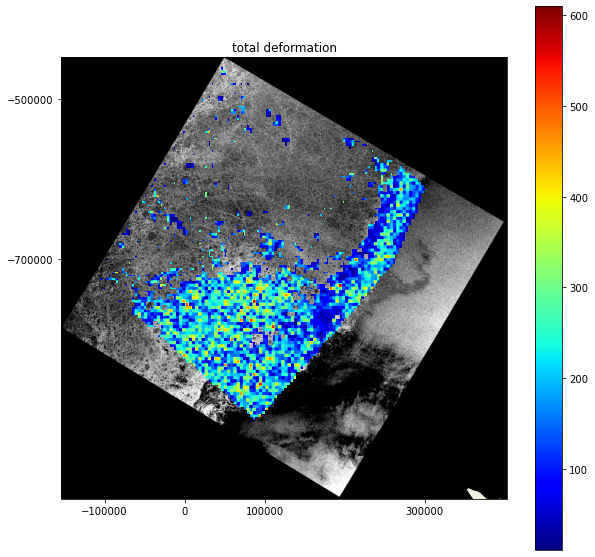

In [76]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

#(axes)  = plt.subplots(2,2, figsize=(30,30), sharex='all', sharey='all')
ax.imshow(n1b1pro, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
im=ax.imshow(total_dr_msk, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap = 'jet') # for transparency  alpha = 0.3
plt.title('total deformation')
#divider = make_axes_locatable(axes[0][0])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#clb1 = plt.colorbar(pm1, cax=cax)
#clb1.ax.set_xlabel(clb_txt)
#clb1.ax.tick_params(labelsize=FS-5)

ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#plt.axes('off')
plt.colorbar(im)

    
    
plt.show()



In [77]:
#EXPORTING DEFORMATION TO POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees
'''maybe export each type to separate file so then just batch them all into rasters'''

e_div_dr

lon1_flat, lat1_flat, lon2_flat,lat2_flat = lon1pm.flatten(),lat1pm.flatten(), lon2pm.flatten(),lat2pm.flatten()

#delta_t = (n2.time_coverage_start - n1.time_coverage_start).total_seconds()
#u = upm / delta_t
#v = vpm / delta_t

divergence, convergence, shear, total, total_div = divergence_dr.flatten(), convergence_dr.flatten(), shear_dr.flatten(), total_dr.flatten(), e_div_dr.flatten()

total_dr_msk = total_dr_msk.flatten()
total_n2 = total_n2.flatten()

In [ ]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, divergence, convergence, shear, total, total_div )
header=['lon1','lat1', 'lon2','lat2', 'divergence','convergence', 'shear','total', 'total_div']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2000m/01-02_sept_2020/01-02_sept_deformation12_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [ ]:
points=zip(lon1_flat,lat1_flat, lon2_flat, lat2_flat, total_n2 )
header=['lon1','lat1', 'lon2','lat2', 'total_n2']

with open('/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2000m/27-28_march_2020/127-28_march_total_n2_12_HH.csv','w') as f:
    out = csv.writer(f, delimiter=',',quoting=csv.QUOTE_ALL)
    out.writerow(header) 
    out.writerows(points)

In [53]:
# export u/v componets into netcdf file
n_out = Nansat.from_domain(dom_pm)
n_out2 = Nansat.from_domain(dom_pm)
n_out.add_bands([u, v], parameters=[{'name': 'u', 'units': 'm/s'}, {'name': 'v', 'units': 'm/s'}])
n_out2.add_bands([apm, rpm, hpm], parameters=[{'name':'a', 'units': '_'}, {'name':'r','units': '_'}, {'name':'h','units': '_'}])


#n_out.export('test_export_uv.nc')
# check exported file with ncdump
#!ncdump -h test_export_uv.nc
n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/01-02_sep_2020_without_ft/01-02_sep_HV_b100_u_v.nc')
n_out2.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/01-02_sep_2020_without_ft/01-02_sep_HV_b100_a_r_h.nc')
#!ncdump -h /home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/14-15_march_2020/14-15_march_HH_u_v.nc
              
#for tiff
n_out.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/01-02_sep_2020_without_ft/01-02_sep_HV_b100_u_v.tif', driver='GTiff')
n_out2.export('/home/jovyan/work/icedrift/Nansen_algorithm/Data_and_output/Nansen_output/01-02_sep_2020_without_ft/01-02_sep_HV_b100_a_r_h.tif', driver='GTiff')
#!gdalinfo test_export_uv.tif

In [ ]:
## Generate test files for simple.py
"""
filenames = [
    'S1B_EW_GRDM_1SDH_20200123T120618_20200123T120718_019944_025BA1_D4A2.SAFE',
    'S1B_EW_GRDM_1SDH_20200125T114955_20200125T115055_019973_025C81_EC1A.SAFE'
]
crop_params = [
    (1800,4400,1000,1000),
    (2400,4600,1000,1000),
]

for f,c in zip(filenames, crop_params): 
    n = Nansat(f)
    n.reproject_gcps()
    n.vrt.tps = True
    n.crop(*c)
    n.export(f[:32]+'.tif', bands=['sigma0_HV'], driver='GTiff')
#"""